### Count regression

This notebook demonstrates the use of tfp for regression on count data. In good statistical tradition, we do not use a testset. We compare again the R-Code and use a standard dataset.

* Poisson Regression
* Zero Infated Poisson Regression
* NB work in progress

#### Links:
Using plain TF
https://github.com/gokceneraslan/neuralnet_countmodels/blob/master/Count%20models%20with%20neuralnets.ipynb


.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


## Loading some count data

We use some traditional count data from: https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta see also: https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/ The data have been processed:


```
dat <- read.dta("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")
dat <- within(dat, {
  prog <- factor(prog, levels = 1:3, labels = c("General", "Academic", "Vocational"))
  id <- factor(id)
})
summary(dat)
m.p <- glm(daysabs ~ math + prog, data = dat,family = poisson)

df = data.frame(model.matrix(m.p))
df$daysabs = dat$daysabs
df$X.Intercept. = NULL
write.table(df, 
            file='~/Documents/workspace/dl_book_playground/nb_data.csv', 
            col.names =FALSE,row.names = FALSE)

```


In [2]:
d = np.loadtxt('nb_data.csv')
X = d[...,0:3]
y = d[...,4]

In [3]:
y.shape, X.shape, X[0:5,]

((314,), (314, 3), array([[63.,  1.,  0.],
        [27.,  1.,  0.],
        [20.,  1.,  0.],
        [16.,  1.,  0.],
        [ 2.,  1.,  0.]]))

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [4]:
## Definition of the custom parametrized distribution
def my_poiss(t):
    return tfd.Poisson(rate=t) #Equivalent to log_rate=t when using linear activation 




In [5]:
my_poiss(np.array((0.0,1.0,2.0,3.0))).mean(), my_poiss(np.array((0.0,1.0,2.0,3.0))).stddev()**2

(<tf.Tensor: id=0, shape=(4,), dtype=float64, numpy=array([0., 1., 2., 3.])>,
 <tf.Tensor: id=6, shape=(4,), dtype=float64, numpy=array([0., 1., 2., 3.])>)

In [6]:
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(3,)) #we need to estimate 3 (2 cat + 1 numerical) coeficient (excluding intercept) 
rate = tf.keras.layers.Dense(1, 
                             activation=tf.exp, #We use the exponential 
                             bias_initializer='zeros', 
                             kernel_initializer='zeros')(inputs)

#p_y = tfp.layers.DistributionLambda(my_poiss)(rate) #<------- Here we hand-in the the custom distribution
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)


In [7]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
hist = model.fit(X, y, epochs=600, verbose=False, validation_split=0.0);

4.422600928036271

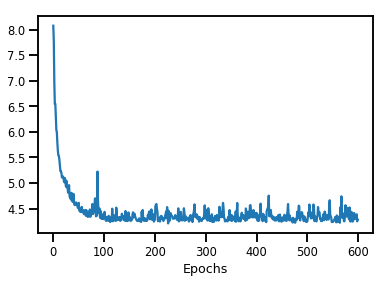

In [8]:
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

In [9]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[-0.00728608],
        [-0.43613392],
        [-1.288468  ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([2.660357], dtype=float32)>]

#### For comparison the results of the r-code?

See also: https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/

* null deviance: only the intercept?
* residual deviace all included

```{r}
> summary(m1 <- glm(daysabs ~ math + prog, data = dat,family = poisson))

Call:
glm(formula = daysabs ~ math + prog, family = poisson, data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.2597  -2.2038  -0.9193   0.6511   7.4233  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.651974   0.060736  43.664  < 2e-16 ***
math           -0.006808   0.000931  -7.313 2.62e-13 ***
progAcademic   -0.439897   0.056672  -7.762 8.35e-15 ***
progVocational -1.281364   0.077886 -16.452  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2217.7  on 313  degrees of freedom
Residual deviance: 1774.0  on 310  degrees of freedom
AIC: 2665.3

Number of Fisher Scoring iterations: 5

> logLik(m1)/314
'log Lik.' -4.231346 (df=4)

```

##### Fitting a glm using the convenions functions in TFP 

In [10]:
# First build the model matrix, appending an intercept term
Xm = np.ones((np.shape(X)[0],np.shape(X)[1]+1))
Xm[:,1:4] = X
Xm[1:4,]
# Doing the fit 
fit = tfp.glm.fit(
    model_matrix=Xm,
    response=y,
    model=tfp.glm.Poisson()
)
fit[0]#2.65197378, -0.00680838, -0.43989746, -1.28136411

<tf.Tensor: id=37559, shape=(4,), dtype=float64, numpy=array([ 2.65197378, -0.00680838, -0.43989746, -1.28136411])>

## Other then Poisson

Other than poisson cases.

### Using zero inflated poisson

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

In [11]:
## Definition of the custom parametrized distribution
def my_zero(t):
    mean = tf.exp(t[:,0]) #Needed so that Poisson has batch_shape=(5,) 
    #print(mean)
    s = tf.math.sigmoid(t[...,1:])
    probs = tf.concat([s, 1-s], axis=1)
    #print(probs)
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#batch_shape=(5,) event_shape=()
          components=[
            tfd.Poisson(rate=mean),   #batch_shape=(5,) event_shape=()
            #tfd.Poisson(rate=0.00001*mean), #Hack to produce 0
            tfd.Deterministic(loc=tf.zeros_like(mean))
        ])

In [12]:
## Testing the distribution
t = np.ones((5,2), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
print(t)
my_zero(t).mean(), tfd.Poisson(tf.exp(1.0)).mean()

W0611 11:15:48.761339 140333529929472 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


[[ 1.     1.   ]
 [ 1.     1.   ]
 [ 1.     1.   ]
 [ 1.     1.   ]
 [ 0.999 10.   ]]


(<tf.Tensor: id=37615, shape=(5,), dtype=float32, numpy=
 array([1.9872233, 1.9872233, 1.9872233, 1.9872233, 2.7154417],
       dtype=float32)>,
 <tf.Tensor: id=37617, shape=(), dtype=float32, numpy=2.7182817>)

In [13]:
## Definition of the model
inputs = tf.keras.layers.Input(shape=(3,))
mean_logit = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(inputs)
p_zero_logit = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(inputs)

# Combining the path
tt = tf.concat([mean_logit, p_zero_logit], axis=1)
p_y_nb = tfp.layers.DistributionLambda(my_zero)(tt)

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y_nb)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            4           input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            4           input_2[0][0]                    
__________________________________________________________________________________________________
concat (TensorFlowOpLayer)      [(None, 2)]          0           dense_1[0][0]                    
                                                                 dense_2[0][0]              

In [14]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
hist = model.fit(X, y, epochs=1200, verbose=False);

3.8213007666882435

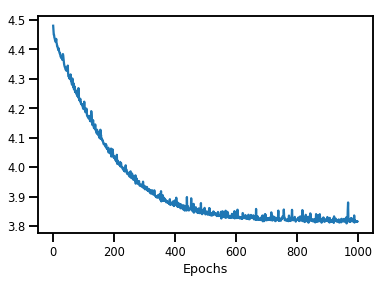

In [15]:
plt.plot(hist.history['loss'][200:])
plt.xlabel('Epochs')
np.mean(hist.history['loss'][1000:]) 

Comparing with R

```
m1.zi = zeroinfl(daysabs ~ math + prog | math + prog, data = dat)
summary(m1.zi)
logLik(m1.zi)/314
Call:
zeroinfl(formula = daysabs ~ math + prog | math + prog, data = dat)

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-2.3410 -1.1702 -0.6026  0.5864  7.3907 

Count model coefficients (poisson with log link):
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.5879178  0.0614173  42.137  < 2e-16 ***
math           -0.0052060  0.0009291  -5.603 2.10e-08 ***
progAcademic   -0.3040946  0.0567438  -5.359 8.36e-08 ***
progVocational -0.9397286  0.0794916 -11.822  < 2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)    -1.920e+01  1.706e+03  -0.011    0.991  
math            1.264e-02  6.926e-03   1.825    0.068 .
progAcademic    1.674e+01  1.706e+03   0.010    0.992  
progVocational  1.766e+01  1.706e+03   0.010    0.992  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 13 
Log-likelihood: -1192 on 8 Df
> logLik(m1.zi)/314
'log Lik.' -3.797503 (df=8)
```

In [16]:
model.get_weights()

[array([[-0.00513406],
        [-0.2881807 ],
        [-0.9255564 ]], dtype=float32),
 array([2.5703218], dtype=float32),
 array([[-0.00844655],
        [-0.31162283],
        [-1.2921721 ]], dtype=float32),
 array([2.6434429], dtype=float32)]

## Using negative binomial (Under construction)

* Problema in TF only has the default parametrization of the NB. Which is not suited. Therefore we stack to distributions (using the gamma-poisson case). Much time has been wasted to construct a single NB distribution from scratch. 

* Question. It seems that in NB there is a globa parameters $\Theta$ it's not modelled depending on data. 

In [17]:
def my_gamma(t):
    mean = t[...,:1] #First column mu
    #disp = 1e-3 + tf.math.softplus(0.05 * t[...,1:]) #Second column sigma
    disp = t[...,1:]
    disp=1.03
    eps = 1e-10
    # translate these into gamma parameters
    gamma_shape = 1. / (disp+eps)
    gamma_scale = (mean / (gamma_shape+eps))+eps
    return tfp.distributions.Gamma(gamma_shape, gamma_scale)

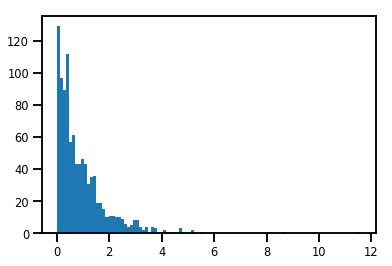

In [221]:
my_gamma(np.ones((1,2))).sample(1000)
plt.hist(my_poiss(my_gamma(np.ones((1,2))).sample(1000)).mean().numpy().reshape((1000,1)),100);

In [223]:
## Definition of the model
#Using the functional API for clarity
inputs   = tf.keras.layers.Input(shape=(3,))
t        = tf.keras.layers.Dense(2, 
                             activation=tf.exp, 
                             bias_initializer='zeros', 
                             #bias_initializer=tf.keras.initializers.Constant(value=2.61),
                             kernel_initializer='zeros')(inputs)
gamma    = tfp.layers.DistributionLambda(my_gamma)(t)  
p_y      = tfp.layers.DistributionLambda(my_poiss)(gamma) 
#Glueing input and output together. Note that output is a tf.distirbution 
model_nb = tf.keras.models.Model(inputs=inputs, outputs=p_y)

In [224]:
model_nb.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
#model_nb.predict(X)

In [225]:
hist = model_nb.fit(X, y, epochs=400, verbose=False);


8.912700449239676

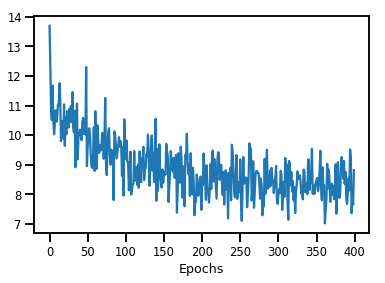

In [226]:
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'][0:]) 

In [227]:
model_nb.weights

[<tf.Variable 'dense_31/kernel:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.00079479,  0.        ],
        [-0.37138182,  0.        ],
        [ 0.5108788 ,  0.        ]], dtype=float32)>,
 <tf.Variable 'dense_31/bias:0' shape=(2,) dtype=float32, numpy=array([-1.7670381,  0.       ], dtype=float32)>]

In [228]:
W = model_nb.weights[0].numpy()
b = model_nb.weights[1].numpy()
W,b
mean_disp = np.matmul(X,W) + b
np.mean(np.exp(mean_disp[:,1]))

1.0